In [19]:
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Silence FutureWarnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Problem Statement (Caleb)

1. Determine and train the best model for classifying galaxies on morphological type (TT response variable) and on Hubble type (spiral, lenticular, irregular), and determine which physical parameters are most important for classification.

2. Recovering known astronomical relationships (e.g. Hubble Constant) from the data and giving a physical sense for our findings.


# Get Data

In [21]:
# Read in the data
processed_galaxies_df = pd.read_csv('../data/preprocessed_data.csv')
processed_galaxies_df= processed_galaxies_df.drop(['Unnamed: 0', 'index'], axis=1)

In [22]:
# Read in data that includes indicator for imputed values
missingness = pd.read_csv('../data/missingness.csv')
missingness= missingness.drop(['Unnamed: 0'], axis=1)

# EDA (John, Adam, Caleb)

# Model Discussion (John, Adam)

Which models could work and why?

* __Multiple Logistic Regression with LASSO Regularization__: Useful in multiclass problems on non-ordinal, categorical response variables. Good for interpretability since we get coefficient estimates to relate predictors and the log-odds of belonging to a specific class; when used with LASSO regularization, parameters are shrunk to zero, preserving the interpretability.

* __Random Forest__: Useful in multi-class, classification problems. Random forests help reduce collinearity between predictors with the randomness involved in decision tree splits. They may also find more complex decision boundaries than just logistic regression due to the non-parametric approach to modeling. Lastly, there is a very straightforward method for feature importance.

* __Gradient Boosting__: Useful in multi-class, classification problems. GB provides good performance with an inbalanced data sets because it trains itself on the residuals; i.e. underrepresented data will have higher error, and thus the model will focus more on those data points on subsequent interations. Lastly, GB may also find more complex decision boundaries than just logistic regression due to the non-parametric approach to modeling. XGBoost, upon further reading, is a very speedy classifier and applies regularization to the model; we have elected to use this implementation.


# Hubble Class

## Model Selection and Tuning

#### Data Preprocessing

1. Get Hubble class (spiral, irregular, lenticular)
2. Split into train and test sets
3. Standardization of quantitative predictors

In [23]:
# Define a variable 'gal_type' that stores the type of galaxy 
processed_galaxies_df['hubble_class'] = 0
processed_galaxies_df['hubble_class'][(processed_galaxies_df['TT'] >= 0) & (processed_galaxies_df['TT'] <= 7)] = 1
processed_galaxies_df['hubble_class'][processed_galaxies_df['TT'] >  7] = 2
## ===== CODE: (0, 1, 2) = (lenticular, spiral, irregular) ===== ##

# Print the percent class breakdowns for each Hubble class
print("Portion Lenticular:", round(np.mean(processed_galaxies_df['hubble_class'] == 0), 3))
print("Portion Spiral:", round(np.mean(processed_galaxies_df['hubble_class'] == 1), 3))
print("Portion Irregular:", round(np.mean(processed_galaxies_df['hubble_class'] == 2), 3))
print("\n")

for i in range(-3, 12, 1):
    print(f"Total, Portion TT={i}:", f"{np.sum(processed_galaxies_df['TT'] == i)},", round(np.mean(processed_galaxies_df['TT'] == i), 3))

Portion Lenticular: 0.197
Portion Spiral: 0.124
Portion Irregular: 0.679


Total, Portion TT=-3: 109, 0.126
Total, Portion TT=-2: 25, 0.029
Total, Portion TT=-1: 36, 0.042
Total, Portion TT=0: 4, 0.005
Total, Portion TT=1: 8, 0.009
Total, Portion TT=2: 2, 0.002
Total, Portion TT=3: 8, 0.009
Total, Portion TT=4: 9, 0.01
Total, Portion TT=5: 9, 0.01
Total, Portion TT=6: 23, 0.027
Total, Portion TT=7: 44, 0.051
Total, Portion TT=8: 106, 0.123
Total, Portion TT=9: 126, 0.146
Total, Portion TT=10: 353, 0.409
Total, Portion TT=11: 2, 0.002


/var/folders/b7/7r72r1kn6x596_mb7pz6xxfc0000gn/T/ipykernel_15608/2227754746.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_galaxies_df['hubble_class'][(processed_galaxies_df['TT'] >= 0) & (processed_galaxies_df['TT'] <= 7)] = 1
/var/folders/b7/7r72r1kn6x596_mb7pz6xxfc0000gn/T/ipykernel_15608/2227754746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_galaxies_df['hubble_class'][processed_galaxies_df['TT'] >  7] = 2


In [37]:
# Instantiate the list of the quantitative predictors
quant_preds = processed_galaxies_df.select_dtypes(include=['number']).columns.drop(['TT', 'hubble_class'])

# Split into train and test sets for hubble class
X_train, X_test, y_train_hubble, y_test_hubble, y_train_TT, y_test_TT = train_test_split(processed_galaxies_df[quant_preds], processed_galaxies_df['hubble_class'], processed_galaxies_df['TT'], random_state=109, test_size=0.2, shuffle=True)

# Instantiate a scaler
standardscaler = StandardScaler().fit(X_train)

# Standardize the data
X_train_std = standardscaler.transform(X_train)
X_test_std = standardscaler.transform(X_test)

# Define a dictionary to store the train and test accuracies of the optimal models throughout this notebook
hubble_accuracies = {}
TT_accuracies = {}

#### Multiple Logistic Regression with LASSO Regularization, Tuned with CV (k=10), Not-SMOTE

In [84]:
# Parameters to tune with SMOTE and CV
param_grid = {'C': np.logspace(-4, 4, 20)}

# Base classifier
logreg_base = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', random_state=109)

# Perform the cross_validation
grid_search = GridSearchCV(logreg_base, param_grid, cv=10, scoring='accuracy').fit(X_train_std, y_train_hubble)
print("Best Parameters:", grid_search.best_params_, "\n")
print("Best Cross-Validation Score:", grid_search.best_score_)

# Fit the best model from the cross validation and compute the train and test accuracies
best_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=grid_search.best_params_['C'], random_state=109).fit(X_train_std, y_train_hubble)

# Calculate train and test accuracy
best_logreg_train_acc = best_logreg.score(X_train_std, y_train_hubble)
best_logreg_test_acc = best_logreg.score(X_test_std, y_test_hubble)
print("Logreg Train Accuracy:", best_logreg_train_acc)
print("Logreg Test Accuracy:", best_logreg_test_acc)

# Store accuracies in the accuracies dictionary
hubble_accuracies['Logreg'] = {
    'train': best_logreg_train_acc,
    'test': best_logreg_test_acc,
    'val': grid_search.best_score_
}


Best Parameters: {'C': 11.288378916846883} 

Best Cross-Validation Score: 0.8683022774327123
Logreg Train Accuracy: 0.8914616497829233
Logreg Test Accuracy: 0.8901734104046243


#### Multiple Logistic Regression with LASSO Regularization, Tuned with CV (k=10), With SMOTE

In [85]:
# Parameters to tune with CV
param_grid = {'log_reg__C': np.logspace(-4, 4, 20)}

# Pipeline for CV with SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=109)),
    ('log_reg', LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', random_state=109))
])    

# Perform the cross_validation
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy').fit(X_train_std, y_train_hubble)
print("Best Parameters:", grid_search.best_params_, "\n")
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model from the cross validation and compute the train and test accuracies
base_best_logreg_SMOTE = LogisticRegression(penalty='l1', solver='liblinear', C=best_params['log_reg__C'], random_state=109)
best_logreg_SMOTE = Pipeline([
    ('smote', SMOTE(random_state=109)),
    ('log_reg', base_best_logreg_SMOTE)
]).fit(X_train_std, y_train_hubble)

# Calculate train and test accuracy
best_logreg_train_acc_SMOTE = best_logreg_SMOTE.score(X_train_std, y_train_hubble)
best_logreg_test_acc_SMOTE = best_logreg_SMOTE.score(X_test_std, y_test_hubble)
print("Logreg-SMOTE Train Accuracy:", best_logreg_train_acc_SMOTE)
print("Logreg-SMOTE Test Accuracy:", best_logreg_test_acc_SMOTE)

# Store accuracies in the accuracies dictionary
hubble_accuracies['Logreg-SMOTE'] = {
    'train': best_logreg_train_acc_SMOTE,
    'test': best_logreg_test_acc_SMOTE,
    'val': grid_search.best_score_
}


Best Parameters: {'log_reg__C': 1.623776739188721} 

Best Cross-Validation Score: 0.8581159420289856
Logreg-SMOTE Train Accuracy: 0.869753979739508
Logreg-SMOTE Test Accuracy: 0.8670520231213873


#### RANDOM FOREST, Tuned with CV (k=10), Not-SMOTE

In [86]:
# Parameters to tune with SMOTE and CV
param_grid = {'max_depth': np.arange(5, 15, 1), 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10]}

# Base classifier
rf_base = RandomForestClassifier(n_estimators=100, random_state=109)

# Perform the cross_validation
grid_search = GridSearchCV(rf_base, param_grid, cv=10, scoring='accuracy').fit(X_train_std, y_train_hubble)
print("Best Parameters:", grid_search.best_params_, "\n")
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model based on the CV, and calculate the train and test accuracies of best estimator
best_rf = RandomForestClassifier(n_estimators=100, max_depth=best_params['max_depth'], criterion=best_params['criterion'], min_samples_split=best_params['min_samples_split'], random_state=109).fit(X_train_std, y_train_hubble)
best_rf_train_acc = best_rf.score(X_train_std, y_train_hubble)
best_rf_test_acc = best_rf.score(X_test_std, y_test_hubble)
print("RF Train Accuracy:", best_rf_train_acc)
print("RF Test Accuracy:", best_rf_test_acc)

hubble_accuracies['random_forest'] = {
    'train': best_rf_train_acc,
    'test' : best_rf_test_acc,
    'val': grid_search.best_score_
}


Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 2} 

Best Cross-Validation Score: 0.8958178053830228
RF Train Accuracy: 1.0
RF Test Accuracy: 0.8786127167630058


#### RANDOM FOREST, Tuned with CV (k=25), With SMOTE

In [87]:
# Parameters to tune with SMOTE and CV
param_grid = {'classifier__max_depth': np.arange(5, 15, 1), 'classifier__criterion': ['gini', 'entropy'], 'classifier__min_samples_split': [2, 5, 10]}

# Pipeline for CV with SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=109)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=109))
])    

# Perform the cross_validation
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy').fit(X_train_std, y_train_hubble)
print("Best Parameters:", grid_search.best_params_, "\n")
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model based on the CV, and calculate the train and test accuracies of best estimator
base_best_rf_SMOTE = RandomForestClassifier(n_estimators=100, max_depth=best_params['classifier__max_depth'], criterion=best_params['classifier__criterion'], min_samples_split=best_params['classifier__min_samples_split'], random_state=109)
best_rf_SMOTE = Pipeline([
    ('smote', SMOTE(random_state=109)),
    ('classifier', base_best_rf_SMOTE)
]).fit(X_train_std, y_train_hubble)

# Calculate train and test accuracy
best_rf_train_acc_SMOTE = best_rf_SMOTE.score(X_train_std, y_train_hubble)
best_rf_test_acc_SMOTE = best_rf_SMOTE.score(X_test_std, y_test_hubble)
print("RF-SMOTE Train Accuracy:", best_rf_train_acc_SMOTE)
print("RF-SMOTE Test Accuracy:", best_rf_test_acc_SMOTE)

hubble_accuracies['random_forest-SMOTE'] = {
    'train': best_rf_train_acc_SMOTE,
    'test' : best_rf_test_acc_SMOTE,
    'val' : grid_search.best_score_
}

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 14, 'classifier__min_samples_split': 5} 

Best Cross-Validation Score: 0.8842443064182195
RF-SMOTE Train Accuracy: 0.9942112879884226
RF-SMOTE Test Accuracy: 0.8786127167630058


#### sklearn Gradient Boosting, Tuned with CV (k=10), Not-SMOTE

In [ ]:
# Parameters to tune with CV
param_grid = {"max_depth": [2, 3, 4], "learning_rate": [0.001, 0.01, 0.1], "n_estimators": [50, 100, 150]}

# base boosting classifier
boost_base = GradientBoostingClassifier(random_state=109)

# Perform grid search
grid_search = GridSearchCV(boost_base, param_grid, cv=10, scoring='accuracy').fit(X_train_std, y_train_hubble)
print("Best Parameters:", grid_search.best_params_, "\n")
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model based on the CV, and calculate the train and test accuracies of best estimator
best_booster = GradientBoostingClassifier(max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], random_state=109).fit(X_train_std, y_train_hubble)
best_booster_train_acc = best_booster.score(X_train_std, y_train_hubble)
best_booster_test_acc = best_booster.score(X_test_std, y_test_hubble)
print("GradBoost Train Accuracy:", best_booster_train_acc)
print("GradBoost Test Accuracy:", best_booster_test_acc)

hubble_accuracies['skl_grad_boost'] = {
    'train': best_booster_train_acc,
    'test' : best_booster_test_acc,
    'val' : grid_search.best_score_
}


Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best Cross-Validation Score: 0.9102691511387162
GradBoost Train Accuracy: 1.0
GradBoost Test Accuracy: 0.9075144508670521


#### sklearn Gradient Boosting, Tuned with CV (k=10), With-SMOTE

In [ ]:
param_grid = { "classifier__max_depth": [2, 3, 4], "classifier__learning_rate": [0.001, 0.01, 0.1], "classifier__n_estimators": [50, 100, 150]}

# Pipeline for CV with SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=109)),
    ('classifier', GradientBoostingClassifier(random_state=109))
])

# Grid serach CV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=1).fit(X_train_std, y_train_hubble)
print("Best Parameters:", grid_search.best_params_, "\n")
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model based on the CV, and calculate the train and test accuracies of best estimator
base_best_booster_SMOTE = GradientBoostingClassifier(max_depth=best_params['classifier__max_depth'], learning_rate=best_params['classifier__learning_rate'], n_estimators=best_params['classifier__n_estimators'], random_state=109)
best_booster_SMOTE = Pipeline([
    ('smote', SMOTE(random_state=109)),
    ('classifier', base_best_booster_SMOTE)
]).fit(X_train_std, y_train_hubble)

# Calculate train and test accuracy
best_booster_train_acc_SMOTE = best_booster_SMOTE.score(X_train_std, y_train_hubble)
best_booster_test_acc_SMOTE = best_booster_SMOTE.score(X_test_std, y_test_hubble)
print("GradBoost Train Accuracy:", best_booster_train_acc_SMOTE)
print("GradBoost Test Accuracy:", best_booster_test_acc_SMOTE)

hubble_accuracies['skl_grad_boost-SMOTE'] = {
    'train': best_booster_train_acc_SMOTE,
    'test' : best_booster_test_acc_SMOTE,
    'val': grid_search.best_score_
}


Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 150} 

Best Cross-Validation Score: 0.916024844720497
GradBoost Train Accuracy: 1.0
GradBoost Test Accuracy: 0.8786127167630058


#### XGBoost Classifier, Tuned with CV (k=10), Not-SMOTE

In [88]:
# Parameters to tune with CV
param_grid = {"max_depth": [2, 3, 4], "learning_rate": [0.001, 0.01, 0.1], "n_estimators": [50, 100, 150]}

# base boosting classifier
XGboost_base = XGBClassifier(random_state=109)

# Perform grid search
grid_search = GridSearchCV(XGboost_base, param_grid, cv=10, scoring='accuracy').fit(X_train_std, y_train_hubble)
print("Best Parameters:", grid_search.best_params_, "\n")
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model based on the CV, and calculate the train and test accuracies of best estimator
best_XGbooster = GradientBoostingClassifier(max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], random_state=109).fit(X_train_std, y_train_hubble)

# Calculate train and test accuracies
best_XGbooster_train_acc = best_XGbooster.score(X_train_std, y_train_hubble)
best_XGbooster_test_acc = best_XGbooster.score(X_test_std, y_test_hubble)
print("GradBoost Train Accuracy:", best_XGbooster_train_acc)
print("GradBoost Test Accuracy:", best_XGbooster_test_acc)

hubble_accuracies['XGBoost'] = {
    'train': best_XGbooster_train_acc,
    'test' : best_XGbooster_test_acc,
    'val' : grid_search.best_score_
}


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150} 

Best Cross-Validation Score: 0.9030020703933748
GradBoost Train Accuracy: 1.0
GradBoost Test Accuracy: 0.9017341040462428


#### XGBoost Classifier, Tuned with CV (k=10), SMOTE

In [89]:
# Parameters to tune with CV
param_grid = { "classifier__max_depth": [2, 3, 4], "classifier__learning_rate": [0.001, 0.01, 0.1], "classifier__n_estimators": [50, 100, 150]}

# Pipeline for CV with SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=109)),
    ('classifier', XGBClassifier(random_state=109))
])

# Grid serach CV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy').fit(X_train_std, y_train_hubble)
print("Best Parameters:", grid_search.best_params_, "\n")
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model based on the CV, and calculate the train and test accuracies of best estimator
base_best_XGbooster_SMOTE = XGBClassifier(max_depth=best_params['classifier__max_depth'], learning_rate=best_params['classifier__learning_rate'], n_estimators=best_params['classifier__n_estimators'], random_state=109)
best_XGbooster_SMOTE = Pipeline([
    ('smote', SMOTE(random_state=109)),
    ('classifier', base_best_XGbooster_SMOTE)
]).fit(X_train_std, y_train_hubble)

# Calculate train and test accuracies
best_XGbooster_train_acc_SMOTE = best_XGbooster_SMOTE.score(X_train_std, y_train_hubble)
best_XGbooster_test_acc_SMOTE = best_XGbooster_SMOTE.score(X_test_std, y_test_hubble)
print("GradBoost Train Accuracy:", best_XGbooster_train_acc_SMOTE)
print("GradBoost Test Accuracy:", best_XGbooster_test_acc_SMOTE)

hubble_accuracies['XGBoost-SMOTE'] = {
    'train': best_XGbooster_train_acc_SMOTE,
    'test' : best_XGbooster_test_acc_SMOTE,
    'val': grid_search.best_score_
}


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 150} 

Best Cross-Validation Score: 0.9000828157349897
GradBoost Train Accuracy: 0.9985528219971056
GradBoost Test Accuracy: 0.8670520231213873


#### Accuracies of Each Model

In [92]:
display(pd.DataFrame(hubble_accuracies).T.sort_values(by="val", ascending=False))

,train,test,val
skl_grad_boost-SMOTE,1.000,0.879,0.916
skl_grad_boost,1.000,0.908,0.910
XGBoost,1.000,0.902,0.903
XGBoost-SMOTE,0.999,0.867,0.900
random_forest,1.000,0.879,0.896
random_forest-SMOTE,0.994,0.879,0.884
Logreg,0.891,0.890,0.868
Logreg-SMOTE,0.870,0.867,0.858


# Best Model Performance Analysis and Visualization

### Plot Training History To Check for Overfitting

In [93]:
best_params_XGBoost = {
    'n_estimators': 50,
    'max_depth': 4,
    'learning_rate': 0.1
}

In [94]:
train_acc = []
test_acc = []
train_acc_smote = []
test_acc_smote = []

# Iterate with increasing model complexity (n_estimators) and get the test and train accuracies
for n_ests in range(1, 151):

    # Get/fit model and get the test and train accuracies
    best_model = XGBClassifier(random_state=109,
                               learning_rate=best_params_XGBoost['learning_rate'],
                               max_depth=best_params_XGBoost['max_depth'],
                               n_estimators=n_ests).fit(X_train_std, y_train_hubble)
    
    train_preds = best_model.predict(X_train_std)
    test_preds = best_model.predict(X_test_std)
    train_acc.append(accuracy_score(y_train_hubble, train_preds))
    test_acc.append(accuracy_score(y_test_hubble, test_preds))
    

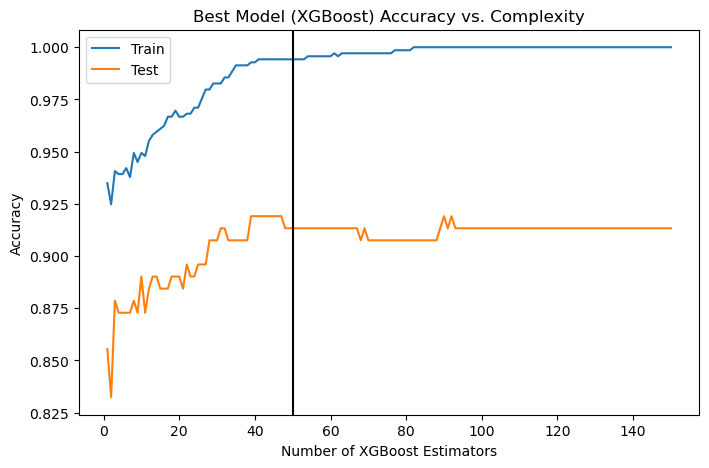

In [95]:
# Plot
n_ests = list(range(1, 151))
plt.figure(figsize=(8, 5))
plt.plot(n_ests, train_acc, label='Train')
plt.plot(n_ests, test_acc, label='Test')
plt.xlabel('Number of XGBoost Estimators')
plt.ylabel('Accuracy')
plt.title("Best Model (XGBoost) Accuracy vs. Complexity")
plt.axvline(50, c='k')
plt.legend()

#### Confusion Matrices

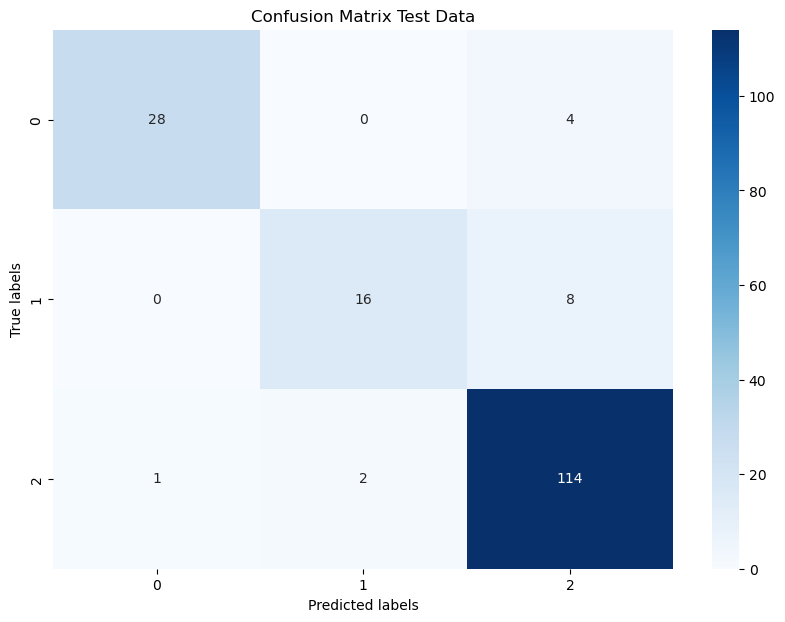

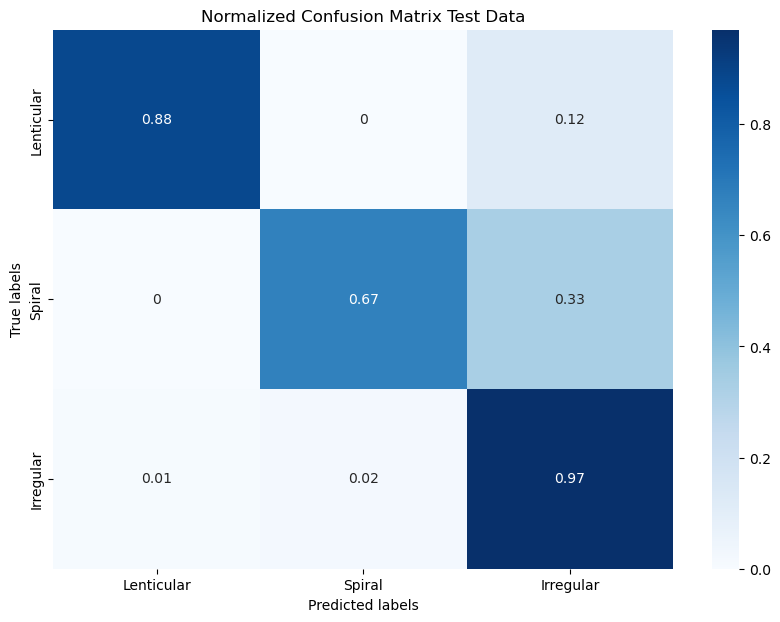

In [96]:
# Get predictions
preds = best_model.predict(X_test_std)

# Get confusion matrix
hub_unique_classes = np.unique(y_test_hubble)
cm = confusion_matrix(y_test_hubble, preds, labels=hub_unique_classes)
cm_sum = np.sum(cm, axis=1)
cm_acc = np.round(cm / np.atleast_2d(cm_sum).T, 2)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=hub_unique_classes, yticklabels=hub_unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test Data')
plt.show()

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
tick_labs = ['Lenticular', 'Spiral', 'Irregular']
sns.heatmap(cm_acc, annot=True, fmt='g', cmap='Blues', xticklabels=tick_labs, yticklabels=tick_labs)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix Test Data')
plt.show()

#### Plot the best model's ROC curve

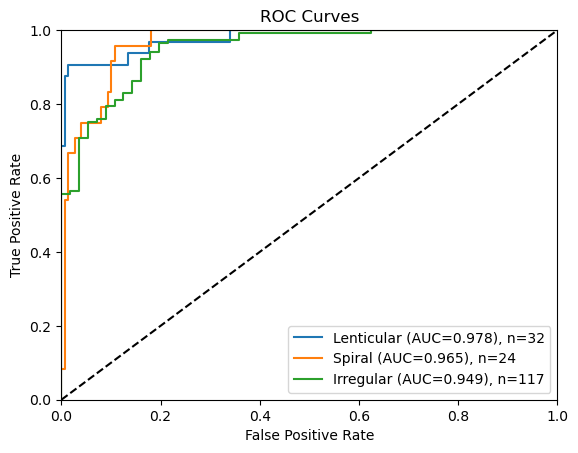

In [97]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get probabilities for the positive class
y_scores = best_model.predict_proba(X_test_std)

# Binarize the output labels for multi-class (basically just one-hot-encoding)
y_test_binarized = label_binarize(y_test_hubble, classes=np.unique(y_test_hubble))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure()
for i, lab in enumerate(['Lenticular', 'Spiral', 'Irregular']):
    plt.plot(fpr[i], tpr[i], label=f'{lab} (AUC={roc_auc[i].round(3)}), n={sum(np.array(y_test_hubble) == i)}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

#### Find feature importances

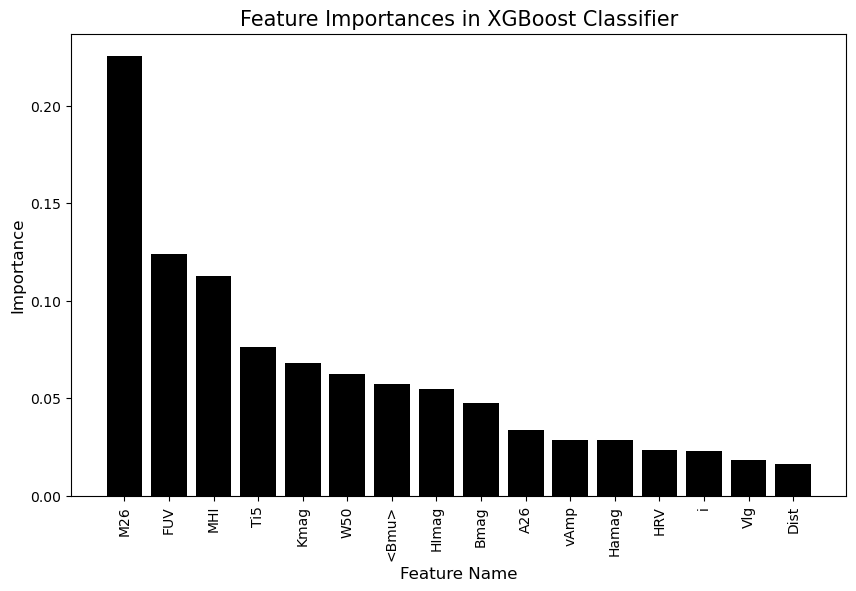

In [98]:
# Get feature importances
feature_importances = best_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in XGBoost Classifier", fontsize=15)
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center', color='k')
plt.xticks(range(len(sorted_indices)), np.array(quant_preds)[sorted_indices], rotation=90)
plt.xlabel('Feature Name', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.show()

# TT Classification

#### XGBoost Classification on TT, Tuned with CV (k=10), Random Over Sampling

In [107]:
# Parameters to tune with CV
param_grid = { "classifier__estimator__max_depth": [2, 3, 4, 5, 6], "classifier__estimator__learning_rate": [0.01, 0.1, 1, 10], "classifier__estimator__n_estimators": [100, 150, 200]}

# Pipeline for CV with ROS
pipeline = Pipeline([
    ('ros', RandomOverSampler(random_state=109)),
    ('classifier', OneVsRestClassifier(XGBClassifier(random_state=109)))
])

# Grid search CV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy').fit(X_train_std, y_train_TT)
print("Best Parameters:", grid_search.best_params_, "\n")
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model based on the CV, and calculate the train and test accuracies of best estimator
base_best_XGbooster_ROS = XGBClassifier(max_depth=best_params['classifier__estimator__max_depth'], learning_rate=best_params['classifier__estimator__learning_rate'], n_estimators=best_params['classifier__estimator__n_estimators'], random_state=109)
ovr_XGBooster_ROS = OneVsRestClassifier(base_best_XGbooster_ROS)
best_XGbooster_ROS = Pipeline([
    ('smote', RandomOverSampler(random_state=109)),
    ('classifier', ovr_XGBooster_ROS)
]).fit(X_train_std, y_train_TT)

# Calculate train and test accuracies
best_XGbooster_train_acc_ROS = best_XGbooster_ROS.score(X_train_std, y_train_TT)
best_XGbooster_test_acc_ROS = best_XGbooster_ROS.score(X_test_std, y_test_TT)
print("GradBoost Train Accuracy:", best_XGbooster_train_acc_ROS)
print("GradBoost Test Accuracy:", best_XGbooster_test_acc_ROS)

TT_accuracies['XGBoost-ROS'] = {
    'train': best_XGbooster_train_acc_ROS,
    'test' : best_XGbooster_test_acc_ROS,
    'val': grid_search.best_score_
}


/Users/johndinovi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'classifier__estimator__learning_rate': 0.1, 'classifier__estimator__max_depth': 5, 'classifier__estimator__n_estimators': 100} 

Best Cross-Validation Score: 0.6164737774997393
GradBoost Train Accuracy: 1.0
GradBoost Test Accuracy: 0.6358381502890174


In [108]:
display(pd.DataFrame(TT_accuracies).T)

,test,train,val
XGBoost-ROS,0.636,1.0,0.616


/var/folders/b7/7r72r1kn6x596_mb7pz6xxfc0000gn/T/ipykernel_15608/1315982244.py:9: RuntimeWarning: invalid value encountered in divide
  cm_acc = np.round(cm / np.atleast_2d(cm_sum).T, 2)


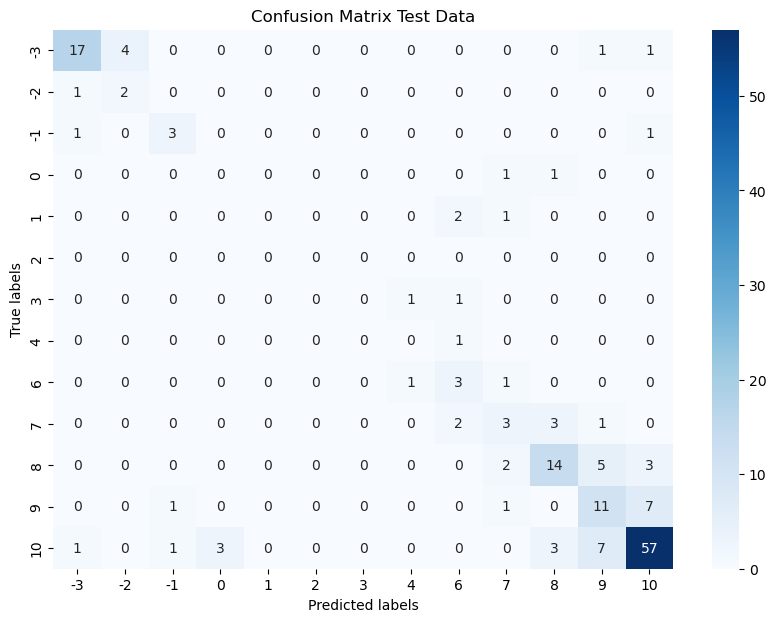

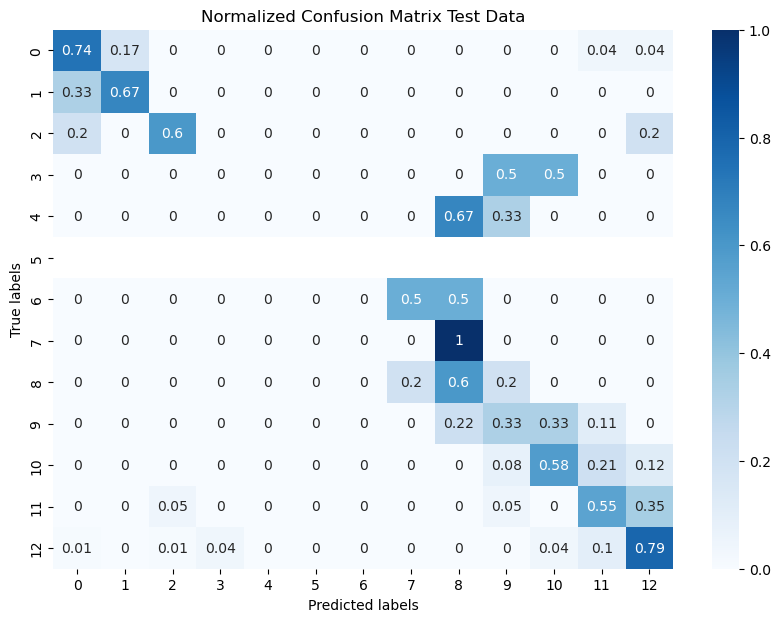

In [112]:
best_model = best_XGbooster_ROS
# Get predictions
preds = best_model.predict(X_test_std)

# Get confusion matrix
TT_unique_classes = np.unique(y_test_TT)
cm = confusion_matrix(y_test_TT, preds, labels=TT_unique_classes)
cm_sum = np.sum(cm, axis=1)
cm_acc = np.round(cm / np.atleast_2d(cm_sum).T, 2)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=TT_unique_classes, yticklabels=TT_unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test Data')
plt.show()

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_acc, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix Test Data')
plt.show()



#### Multiple Logistic Regression with LASSO Regularization, Tuned with CV (k=25)

#### Multiple Logistic Regression with LASSO Regularization, Tuned with CV (k=10), Random Over Sampling

In [ ]:
# Parameters to tune with SMOTE and CV
param_grid = {'C': np.logspace(-4, 4, 20)}

# Base classifier
logreg_base = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', random_state=109, max_iter=10000)
pipeline_ros = Pipeline([
    ('ros', RandomOverSampler(random_state=109)),
    ('classifier', logreg_base)
])

# Perform the cross_validation
grid_search = GridSearchCV(logreg_base, param_grid, cv=25, scoring='accuracy', verbose=2).fit(X_train_std, y_train_TT)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Fit the best model from the cross validation and compute the train and test accuracies
best_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=grid_search.best_params_['C']).fit(X_train_std, y_train_TT)
best_logreg_train_acc = best_logreg.score(X_train_std, y_train_TT)
best_logreg_test_acc = best_logreg.score(X_test_std, y_test_TT)
print("Logreg Train Accuracy:", best_logreg_train_acc)
print("Logreg Test Accuracy:", best_logreg_test_acc)

# Store accuracies in the accuracies dictionary
TT_accuracies['Logreg'] = {
    'train': best_logreg_train_acc,
    'test': best_logreg_test_acc,
    'val': grid_search.best_score_
}

In [37]:
# Parameters to tune with CV
param_grid = {'max_depth': np.arange(5, 15, 1), 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10]}

# Base classifier
rf_base = RandomForestClassifier(n_estimators=100, random_state=109)

# Perform the cross_validation
grid_search = GridSearchCV(rf_base, param_grid, cv=25, scoring='accuracy').fit(X_train_std, y_train_TT)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model based on the CV, and calculate the train and test accuracies of best estimator
best_rf = RandomForestClassifier(n_estimators=100, max_depth=best_params['max_depth'], criterion=best_params['criterion'], min_samples_split=best_params['min_samples_split'], random_state=109).fit(X_train_std, y_train_TT)
best_rf_train_acc = best_rf.score(X_train_std, y_train_TT)
best_rf_test_acc = best_rf.score(X_test_std, y_test_TT)
print("RF Train Accuracy:", best_rf_train_acc)
print("RF Test Accuracy:", best_rf_test_acc)

TT_accuracies['random_forest'] = {
    'train': best_rf_train_acc,
    'test' : best_rf_test_acc,
    'val': grid_search.best_score_
}


/Users/johndinovi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=25.
  warnings.warn(


Best Parameters: {'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 5}
Best Cross-Validation Score: 0.6279365079365079
RF Train Accuracy: 0.9696092619392185
RF Test Accuracy: 0.653179190751445


In [38]:
# Parameters to tune with CV
param_grid = {"max_depth": [2, 3, 4], "learning_rate": [0.001, 0.01, 0.1], "n_estimators": [50, 100, 150]}

# base boosting classifier
boost_base = GradientBoostingClassifier(random_state=109)

# Perform grid search
grid_search = GridSearchCV(boost_base, param_grid, cv=10, scoring='accuracy', verbose=1).fit(X_train_std, y_train_TT)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
best_params = grid_search.best_params_

# Fit the best model based on the CV, and calculate the train and test accuracies of best estimator
best_booster = GradientBoostingClassifier(max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], random_state=109).fit(X_train_std, y_train_TT)
best_booster_train_acc = best_booster.score(X_train_std, y_train_TT)
best_booster_test_acc = best_booster.score(X_test_std, y_test_TT)
print("GradBoost Train Accuracy:", best_booster_train_acc)
print("GradBoost Test Accuracy:", best_booster_test_acc)

TT_accuracies['skl_grad_boost'] = {
    'train': best_booster_train_acc,
    'test' : best_booster_test_acc,
    'val' : grid_search.best_score_
}


Fitting 10 folds for each of 27 candidates, totalling 270 fits


/Users/johndinovi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Cross-Validation Score: 0.6006211180124224
GradBoost Train Accuracy: 1.0
GradBoost Test Accuracy: 0.5722543352601156
